In [1]:
### Import required libraries ###
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torchvision 
batch_size_test = 100
batch_size_train = 1000
root = "/Users/robinlin/Desktop/Code"
datatrain = torchvision.datasets.FashionMNIST(root, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
datatest = torchvision.datasets.FashionMNIST(root, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_loader = torch.utils.data.DataLoader(datatrain,
                                          batch_size=batch_size_train,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(datatest, batch_size=batch_size_test, shuffle=True)

Extracting /Users/robinlin/Desktop/Code/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/robinlin/Desktop/Code/FashionMNIST/raw


Extracting /Users/robinlin/Desktop/Code/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/robinlin/Desktop/Code/FashionMNIST/raw


Extracting /Users/robinlin/Desktop/Code/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/robinlin/Desktop/Code/FashionMNIST/raw


Extracting /Users/robinlin/Desktop/Code/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/robinlin/Desktop/Code/FashionMNIST/raw
Processing...
Done!


torch.Size([100, 1, 28, 28])

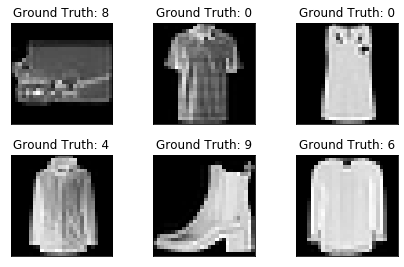

In [3]:
print(train_loader)
print(test_loader)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

example_data.shape

In [4]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=(5,5), stride=1)
        self.batchnorm1 = nn.BatchNorm2d(num_features=20)
        self.batchnorm2 = nn.BatchNorm2d(num_features=50)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=(5,5), stride=1)
        self.conv3 = nn.Conv2d(50, 50, kernel_size=(3,3), stride=1)
        self.fc1 = nn.Linear(16200, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.relu(self.batchnorm2(self.conv3(x)))
        x = x.view(-1, 16200)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=(5,5), stride=1)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=(5,5), stride=1)
        self.conv3 = nn.Conv2d(50, 50, kernel_size=(3,3), stride=1)
        self.fc1 = nn.Linear(16200, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu((self.conv1(x)))
        x = F.relu((self.conv2(x)))
        x = F.relu((self.conv3(x)))
        x = x.view(-1, 16200)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

cnn = Net1()
cnn2 = Net2()
print(cnn)
print(cnn2)

Net1(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=16200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Net2(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=16200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
def fit(model, train_loader,trainacc,losslist):
    optimizer = torch.optim.Adagrad(model.parameters(),lr=0.003)
    error = nn.CrossEntropyLoss()
    EPOCHS = 200
    model.train()
    for epoch in range(EPOCHS):
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()
            predicted = torch.max(output.data, 1)[1] 
            print("Accuracy:")
            print(((predicted == var_y_batch).sum()).double()/batch_size_train)
            trainacc.append(((predicted == var_y_batch).sum()).double()/batch_size_train)
            print("Loss:")
            print(loss)
            losslist.append(loss)
            print("Epoch:")
            print(epoch)
            print("Batch:")
            print(batch_idx)

    

In [7]:
# with batch normalization
trainacc = []
loss = []
fit(cnn,train_loader,trainacc,loss)


Accuracy:
tensor(0.3510, dtype=torch.float64)
Loss:
tensor(4.4679, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
0
Accuracy:
tensor(0.2720, dtype=torch.float64)
Loss:
tensor(13.7722, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
1
Accuracy:
tensor(0.2620, dtype=torch.float64)
Loss:
tensor(10.9321, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
2
Accuracy:
tensor(0.2900, dtype=torch.float64)
Loss:
tensor(7.7541, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
3
Accuracy:
tensor(0.3360, dtype=torch.float64)
Loss:
tensor(6.6721, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
4
Accuracy:
tensor(0.5160, dtype=torch.float64)
Loss:
tensor(2.6703, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
5
Accuracy:
tensor(0.6080, dtype=torch.float64)
Loss:
tensor(1.4389, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
6
Accuracy:
tensor(0.6550, dtype=torch.float64)
Loss:
tensor(1.0743, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
7
Accuracy:
tensor(0.7140, dtype=torch.float64)
Loss:
tensor(0.8686, grad_fn=<NllLossBackward>)
Epoch:
0

Accuracy:
tensor(0.8380, dtype=torch.float64)
Loss:
tensor(0.4652, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
13
Accuracy:
tensor(0.8300, dtype=torch.float64)
Loss:
tensor(0.4959, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
14
Accuracy:
tensor(0.8020, dtype=torch.float64)
Loss:
tensor(0.4811, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
15
Accuracy:
tensor(0.8010, dtype=torch.float64)
Loss:
tensor(0.5634, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
16
Accuracy:
tensor(0.8500, dtype=torch.float64)
Loss:
tensor(0.4189, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
17
Accuracy:
tensor(0.8590, dtype=torch.float64)
Loss:
tensor(0.4015, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
18
Accuracy:
tensor(0.8460, dtype=torch.float64)
Loss:
tensor(0.4268, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
19
Accuracy:
tensor(0.8590, dtype=torch.float64)
Loss:
tensor(0.4307, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
20
Accuracy:
tensor(0.8500, dtype=torch.float64)
Loss:
tensor(0.4442, grad_fn=<NllLossBackward>)
Ep

Accuracy:
tensor(0.8370, dtype=torch.float64)
Loss:
tensor(0.4144, grad_fn=<NllLossBackward>)
Epoch:
2
Batch:
26
Accuracy:
tensor(0.8750, dtype=torch.float64)
Loss:
tensor(0.3735, grad_fn=<NllLossBackward>)
Epoch:
2
Batch:
27
Accuracy:
tensor(0.8530, dtype=torch.float64)
Loss:
tensor(0.4354, grad_fn=<NllLossBackward>)
Epoch:
2
Batch:
28
Accuracy:
tensor(0.8670, dtype=torch.float64)
Loss:
tensor(0.3583, grad_fn=<NllLossBackward>)
Epoch:
2
Batch:
29
Accuracy:
tensor(0.8360, dtype=torch.float64)
Loss:
tensor(0.4766, grad_fn=<NllLossBackward>)
Epoch:
2
Batch:
30
Accuracy:
tensor(0.8410, dtype=torch.float64)
Loss:
tensor(0.4035, grad_fn=<NllLossBackward>)
Epoch:
2
Batch:
31
Accuracy:
tensor(0.8700, dtype=torch.float64)
Loss:
tensor(0.3644, grad_fn=<NllLossBackward>)
Epoch:
2
Batch:
32
Accuracy:
tensor(0.8430, dtype=torch.float64)
Loss:
tensor(0.4006, grad_fn=<NllLossBackward>)
Epoch:
2
Batch:
33
Accuracy:
tensor(0.8570, dtype=torch.float64)
Loss:
tensor(0.3690, grad_fn=<NllLossBackward>)
Ep

KeyboardInterrupt: 

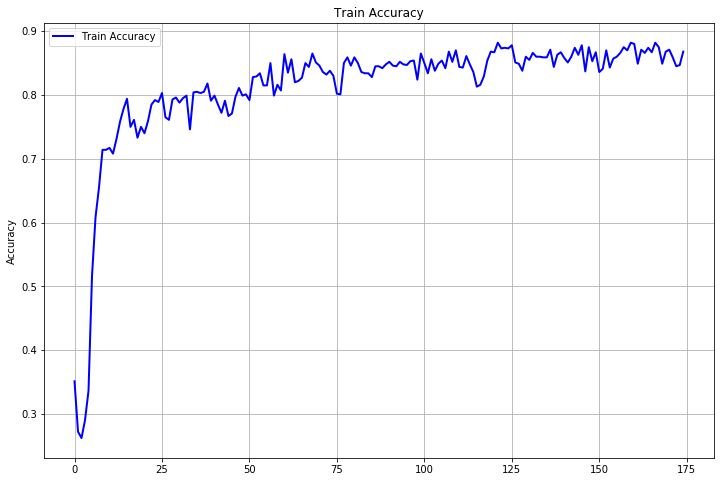

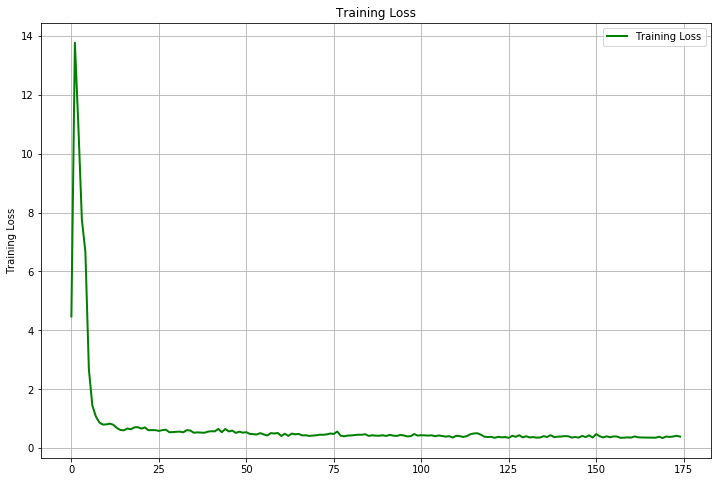

In [8]:
plt.figure(1, figsize=(12, 8))
plt.plot(trainacc, '-', color='blue',linewidth=2, label='Train Accuracy')
plt.title('Train Accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(1, figsize=(12, 8))
plt.plot(loss, '-', color='green',linewidth=2, label='Training Loss')
plt.title('Training Loss')
plt.ylabel('Training Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [9]:
# without batch normalization
trainacc = []
loss = []
fit(cnn2,train_loader,trainacc,loss)


Accuracy:
tensor(0.0860, dtype=torch.float64)
Loss:
tensor(2.3021, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
0
Accuracy:
tensor(0.3070, dtype=torch.float64)
Loss:
tensor(4.1489, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
1
Accuracy:
tensor(0.1060, dtype=torch.float64)
Loss:
tensor(5.3615, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
2
Accuracy:
tensor(0.2320, dtype=torch.float64)
Loss:
tensor(2.3098, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
3
Accuracy:
tensor(0.4090, dtype=torch.float64)
Loss:
tensor(2.1202, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
4
Accuracy:
tensor(0.3400, dtype=torch.float64)
Loss:
tensor(1.8955, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
5
Accuracy:
tensor(0.2670, dtype=torch.float64)
Loss:
tensor(1.8519, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
6
Accuracy:
tensor(0.4670, dtype=torch.float64)
Loss:
tensor(1.5654, grad_fn=<NllLossBackward>)
Epoch:
0
Batch:
7
Accuracy:
tensor(0.6300, dtype=torch.float64)
Loss:
tensor(1.1496, grad_fn=<NllLossBackward>)
Epoch:
0
B

Accuracy:
tensor(0.8420, dtype=torch.float64)
Loss:
tensor(0.4592, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
13
Accuracy:
tensor(0.7940, dtype=torch.float64)
Loss:
tensor(0.5365, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
14
Accuracy:
tensor(0.7770, dtype=torch.float64)
Loss:
tensor(0.6071, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
15
Accuracy:
tensor(0.7720, dtype=torch.float64)
Loss:
tensor(0.5725, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
16
Accuracy:
tensor(0.8000, dtype=torch.float64)
Loss:
tensor(0.5053, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
17
Accuracy:
tensor(0.8020, dtype=torch.float64)
Loss:
tensor(0.5372, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
18
Accuracy:
tensor(0.8270, dtype=torch.float64)
Loss:
tensor(0.4649, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
19
Accuracy:
tensor(0.8110, dtype=torch.float64)
Loss:
tensor(0.5088, grad_fn=<NllLossBackward>)
Epoch:
1
Batch:
20
Accuracy:
tensor(0.7910, dtype=torch.float64)
Loss:
tensor(0.5420, grad_fn=<NllLossBackward>)
Ep

KeyboardInterrupt: 

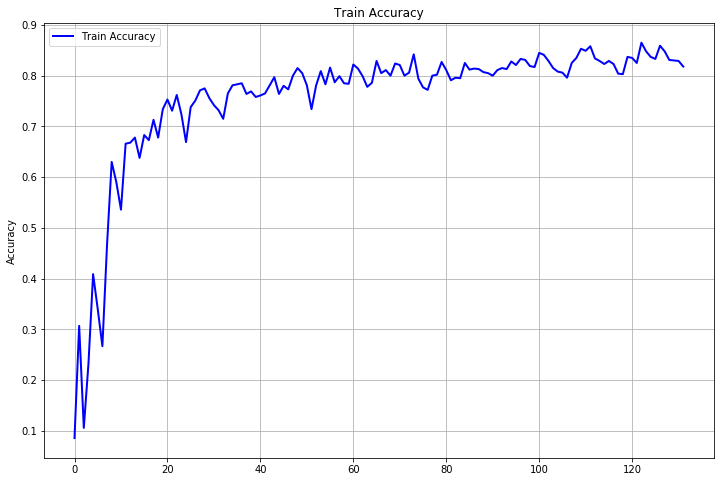

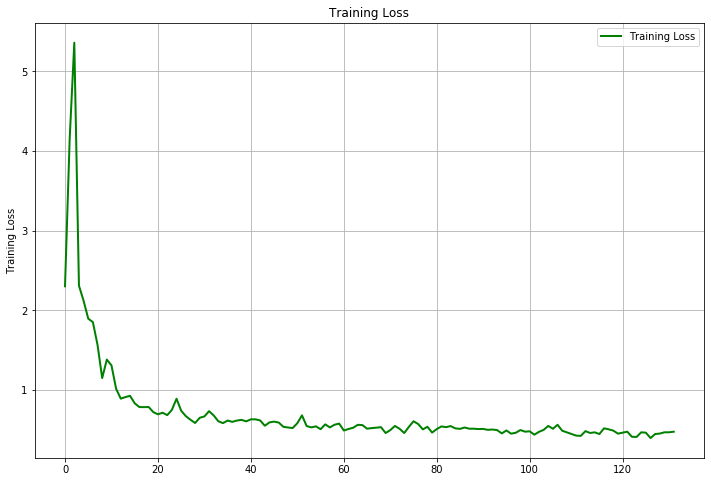

In [10]:
plt.figure(1, figsize=(12, 8))
plt.plot(trainacc, '-', color='blue',linewidth=2, label='Train Accuracy')
plt.title('Train Accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(1, figsize=(12, 8))
plt.plot(loss, '-', color='green',linewidth=2, label='Training Loss')
plt.title('Training Loss')
plt.ylabel('Training Loss')
plt.legend(loc='best')
plt.grid()
plt.show()